In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

from os.path import join

from scipy.stats import fligner, t
from nilearn import plotting, datasets, surface

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
morph_pal = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal

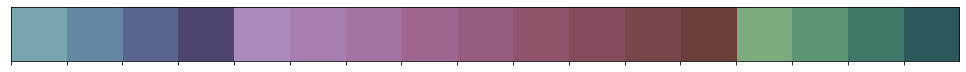

In [3]:
sns.palplot(big_pal)

In [4]:
sns.set(style="white", 
        context="talk", 
        font_scale=0.8,
        rc={"axes.facecolor": (0, 0, 0, 0),
            "font.monospace": 'Courier',
            "font.family": 'monospace'})
crayons = sns.crayon_palette(['Aquamarine', 'Burnt Sienna', 'Jungle Green', 'Fuchsia', 'Lavender'])

In [5]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [6]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

In [7]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [8]:

deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

#morph = img_modalities['smri'].filter(regex='.*vol.*').columns

In [9]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
rsi_scs = list(img_modalities['rsi'].filter(regex='.*scs').columns)
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [10]:
imaging_apd = list(deltasmri_complete.columns) + list(deltadti_complete.columns) + list(deltarsi_complete.columns) + list(deltarsfmri_complete.columns)

In [11]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd',
                     'dtild', 
                     'dtitd'],
            'func':['var',
                    'c',
                    'cor',
                    #'subcortical-network fc'
                   ]}

In [12]:
# need to calculate mean & sd for each imaging variable change score
descriptives = pd.DataFrame(columns=['annualized percent change', 'sdev', 'concept', 'atlas', 'measure'])
for var in imaging_apd:
    descriptives.at[var,'annualized percent change'] = df[var].mean()
    descriptives.at[var,'sdev'] = df[var].std()
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        descriptives.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            descriptives.at[var, 'concept'] = 'cellular architecture'
            descriptives.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'vol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        descriptives.at[var, 'measure'] = var_list[1]
        descriptives.at[var, 'atlas'] = var_list[2]
        if var_list[1] in concepts['morph']:
            descriptives.at[var, 'concept'] = 'macrostructure'
        elif var_list[1] in concepts['cell']:
            descriptives.at[var, 'concept'] = 'cellular architecture'
        if var_list[1] in concepts['func']:
            descriptives.at[var, 'concept'] = 'function'
        if var in btwn_fc:
            descriptives.at[var, 'measure'] = 'between-network fc'
        elif var in wthn_fc:
            descriptives.at[var, 'measure'] = 'within-network fc'
        elif var in fc_scor_var:
            descriptives.at[var, 'measure'] = 'subcortical-network fc'
        elif var in rsi_scs:
            if 'rsirni' in var:
                descriptives.at[var, 'measure'] = 'rsirnigm'
            elif 'rsirnd' in var:
                descriptives.at[var, 'measure'] = 'rsirndgm'
            

In [13]:
descriptives[descriptives['measure'] == 'dtimd']

,annualized percent change,sdev,concept,atlas,measure
dmri_dtimd_fiberat_fxrh.change_score,-0.372312,2.94606,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_fxlh.change_score,-0.320375,2.787618,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cgcrh.change_score,-0.672789,2.362524,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cgclh.change_score,-0.89197,2.540198,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cghrh.change_score,-1.029742,2.506963,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cghlh.change_score,-0.909958,2.312225,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cstrh.change_score,-0.637472,1.804067,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_cstlh.change_score,-0.631223,1.823046,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_atrrh.change_score,-0.323661,2.031139,cellular architecture,fiberat,dtimd
dmri_dtimd_fiberat_atrlh.change_score,-0.391101,2.019033,cellular architecture,fiberat,dtimd


In [14]:
drop = ['dtx', 'meanmotion',
       'subthreshnvols', 'subtcignvols', 'ntpoints']
drop_var = []
for var in drop:
    drop_var += list(descriptives[descriptives['atlas'] == var].index)

In [15]:
descriptives.drop(list(drop_var), axis=0, inplace=True)

In [16]:
measures = list(descriptives['measure'].unique())
concepts = ['macrostructure', 'microstructure', 'function']

In [17]:
long_names = {'var': 'BOLD',
              'between-network fc': 'FC (btwn)',
              'within-network fc': 'FC (wthn)',
              'subcortical-network fc': 'FC (sc)',
              'dtivol': 'WMV',
              'vol': 'GMV',
              'thick': 'CT',
              'area': 'CA',
              'dtifa': 'FA',
              'dtimd': 'MD',
              'dtild': 'LD',
              'dtitd': 'TD',
              'rsirni': 'RNI',
              'rsirnd': 'RND',
              'rsirnigm': 'RNI (gm)',
              'rsirndgm': 'RND (gm)',
              't1wcnt': 'G/W'}

In [18]:
sub_df = descriptives[descriptives['concept'] == 'macrostructure']
sub2_df = descriptives[descriptives['concept'] == 'cellular architecture']
sub_df = pd.concat([sub_df, sub2_df])
sub_df.replace(long_names, inplace=True)

In [19]:
morph_cell_pal = morph_pal + cell_pal

In [20]:
sub_df['measure'].unique()

array(['GMV', 'CA', 'CT', 'WMV', 'G/W', 'FA', 'MD', 'LD', 'TD', 'RNI',
       'RNI (gm)', 'RND', 'RND (gm)'], dtype=object)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


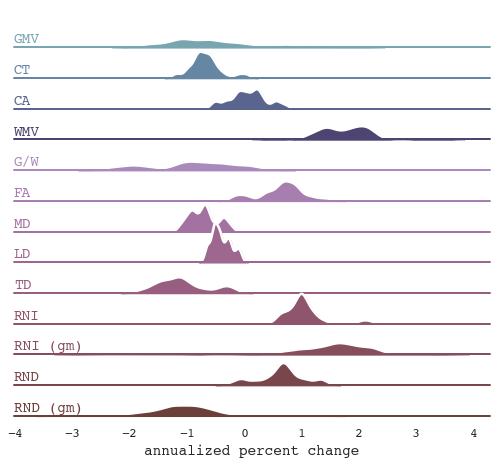

In [21]:
g = sns.FacetGrid(sub_df, 
                  row="measure", row_order=['GMV', 'CT', 'CA', 'WMV', 
                                            'G/W', 'FA','MD', 'LD', 'TD',
                                            'RNI', 'RNI (gm)','RND','RND (gm)'],
                  hue="measure", hue_order=['GMV', 'CT', 'CA', 'WMV', 
                                            'G/W', 'FA','MD', 'LD', 'TD',
                                            'RNI', 'RNI (gm)','RND','RND (gm)'],
                  aspect=15, height=.5, palette=morph_cell_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_morpcell.png', dpi=400)

In [22]:
sub_df = descriptives[descriptives['concept'] == 'function']
sub_df2 = descriptives[descriptives['concept'] == 'function']
sub_df.replace(long_names, inplace=True)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


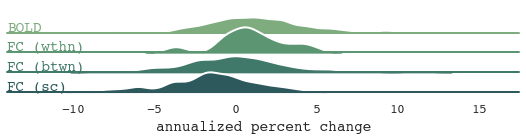

In [23]:
g = sns.FacetGrid(sub_df, row="measure", hue="measure", aspect=16, height=.5, palette=func_pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_function.png', dpi=400)

In [24]:
desc_summ = pd.DataFrame(index=measures, columns=['mean', 'sdev', '95%CI'])
for measure in measures:
    temp_df = descriptives[descriptives['measure'] == measure]
    mean = np.mean(temp_df['annualized percent change'])
    desc_summ.at[measure, 'mean'] = np.round(mean,2)
    sdev = np.mean(temp_df['sdev'])
    desc_summ.at[measure, 'sdev'] = np.round(sdev,2)
    dof = len(temp_df.index)-1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    CI = (np.round(mean - sdev *t_crit / np.sqrt(dof + 1), 2), np.round(mean + sdev * t_crit / np.sqrt(dof + 1),2)) 
    desc_summ.at[measure, '95%CI'] = CI

In [25]:
desc_summ

,mean,sdev,95%CI
vol,-0.48,2.66,"(-1.04, 0.07)"
area,0.07,2.48,"(-0.53, 0.67)"
thick,-0.67,1.85,"(-1.12, -0.22)"
t1wcnt,-0.93,4.0,"(-1.9, 0.04)"
dtifa,0.64,2.52,"(-0.18, 1.47)"
dtimd,-0.71,2.02,"(-1.37, -0.04)"
dtild,-0.4,2.04,"(-1.07, 0.27)"
dtitd,-1.07,2.23,"(-1.8, -0.34)"
dtivol,1.79,2.93,"(0.83, 2.75)"
rsirni,1.04,1.85,"(0.36, 1.72)"


In [26]:
df.min()

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_5557/3962516015.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.min()


mrirsfd112.baseline_year_1_arm_1                     0.000509
mrirsfd9.baseline_year_1_arm_1                       0.001251
mrirsfd107.2_year_follow_up_y_arm_1                  0.002356
mrirsfd103.baseline_year_1_arm_1                     0.000138
mrirsfd4.2_year_follow_up_y_arm_1                    0.002805
                                                      ...    
dmri_rsirndgm_cdx_sttrh.2_year_follow_up_y_arm_1     0.131407
dmri_rsirndgm_cdx_sttrh.change_score               -58.090791
dmri_rsirndgm_cdx_mean.baseline_year_1_arm_1         0.175509
dmri_rsirndgm_cdx_mean.2_year_follow_up_y_arm_1      0.178474
dmri_rsirndgm_cdx_mean.change_score                -58.561716
Length: 7696, dtype: object

In [27]:
# let's visualize APD!
destrieux = datasets.fetch_atlas_destrieux_2009()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

Reading local neurovault data.
Already fetched 1 image
1 image found on local disk.


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [29]:
def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    '''
    Plots of medial and lateral left and right surface views from nifti volume
    '''
    
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation='nearest')
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation='nearest')
    
    fig = plt.figure(figsize=(12,4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection='3d')
    ax1 = fig.add_subplot(gs[1], projection='3d')
    ax2 = fig.add_subplot(gs[2], projection='3d')
    ax3 = fig.add_subplot(gs[3], projection='3d')
    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax0)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax1)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax2)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax3)
    return figure

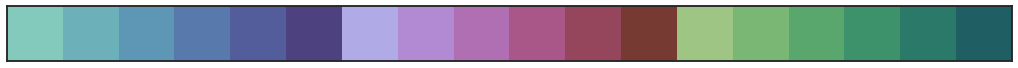

In [31]:
morph_pal = sns.cubehelix_palette(start=0.6, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=1, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(start=1.7, rot=-0.8, gamma=1.0, hue=1, light=0.7, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.5, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(start=3.0, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal
sns.palplot(big_pal)

In [32]:
nifti_mapping = pd.read_csv(join(PROJ_DIR, 
                                 DATA_DIR, 
                                 'variable_to_nifti_mapping.csv'), 
                            header=0, 
                            index_col=0)

In [28]:
# list of measures to plot
measures = {'cortical-thickness': 'smri_thick_cdk_*change_score',
            'cortical-gwcontrast': 'smri_t1wcnt_cdk_*change_score',
            'cortical-area': 'smri_area_cdk_.*change_score',
            'cortical-volume': 'smri_vol_cdk_.*change_score', 
            'subcortical-volume': 'smri_vol_scs_.*change_score', 
            'subcortical-RND': 'dmri_rsirnd_scs_.*change_score',
            'subcortical-RNI': 'dmri_rsirni_scs_.*change_score',
            'cortical-RND': 'dmri_rsirndgm_.*change_score',
            'cortical-RNI': 'dmri_rsirnigm_.*change_score',
            'cortical-BOLD-variance': 'rsfmri_var_cdk_.*change_score',
            'tract-volume': 'dmri_dtivol_fiberat_.*change_score', 
            'tract-FA': 'dmri_dtifa_fiberat_.*change_score', 
            'tract-MD': 'dmri_dtimd_fiberat_.*change_score'
            'tract-LD': 'dmri_dtild_fiberat_.*change_score', 
            'tract-TD': 'dmri_dtitd_fiberat_.*change_score', 
            'tract-RND': 'dmri_rsirnd_fib_.*change_score',
            'tract-RNI': 'dmri_rsirni_fib_.*change_score'}

conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*change_score',
            'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*change_score',}

In [ ]:
for measure in measures:
    print(measure)
    meas_df = df.filter(regex=measures[measure], axis=0)
    print(len(meas_df.index))
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in meas_df.index:
        if 'cdk_total' in i:
            pass
        else:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            else:
                if var_df.at[i,(fligner_var, 'a<0.05')] == '**':
                    sig += 1
                    plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
                else:
                    plotting_arr[np.where(atlas_arr == value)] = 0
    print('plotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions\n avg val: {np.mean(plotting_arr)}')
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    if 'subcortical' in measure:
        grid_kw = dict(width_ratios=[3,1])

        fig,ax = plt.subplots(#ncols=2, gridspec_kw=grid_kw, figsize=(24,4)
                             )
        plt.figure(layout='tight')
        q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                               cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                               annotate=False, cmap=pals[measure], colorbar=False,
                               symmetric_cbar=False, axes=ax)

        #ax[1].set_visible(False)
        q.savefig(f'../figures/{fligner}x{measure}_fk_scs.png', dpi=400)
    elif measure in tract_measures.keys():
        fibers = nifti_mapping.filter(regex=tract_measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    print(np.unique(tract_arr))
                    if var_df.at[f'{var}.change_score',(fligner_var, 'a<0.05')] == '**':
                        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                    else:
                        tract_arr *= 0
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=1,
                               cut_coords=[35,50,65,85], 
                               black_bg=False,
                                   vmax=vmax*1.1, 
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   #axes=ax[0]
                              )
        #ax[1].set_visible(False)
        q.savefig(f'../figures/{fligner}x{measure}_fk_tract.png', dpi=400)
    elif 'cortical' in measure:
        figure = plot_surfaces(meas_nimg, fsaverage, pals[measure], vmax, 1)
        #texture_l = surface.vol_to_surf(meas_nimg, fsaverage.pial_left, interpolation='nearest')
        #texture_r = surface.vol_to_surf(meas_nimg, fsaverage.pial_right, interpolation='nearest')

        #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                             #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftmed.png', dpi=400)
        #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                             #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftlat.png', dpi=400)
        #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                             #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        #figure.savefig(f'../figures/{measure}x{fligner}_fk_rightlat.png', dpi=400)
        #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                             #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
        #plt.tight_layout(pad=2)
        figure.savefig(f'../figures/{fligner}x{measure}_fk.png', dpi=400)